# 动量法

下面我们手动实现一个动量法，公式
$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$

$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率

In [1]:
def sgd_momentum(parameters, vs, lr, gamma):
    for param, v in zip(parameters, vs):
        v[:] = gamma * v + lr * param.grad.data
        param.data = param.data - v

In [2]:
import numpy as np
import torch as t
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def data_tf(x):
    x = np.array(x, dtype = 'float32') / 255
    x = (x - 0.5) / 0.5
    x = x.reshape((-1,))
    x = t.from_numpy(x)
    return x

In [4]:
train_set = MNIST('./data', train = True, transform = data_tf, download = True)
test_set = MNIST('./data', train = False, transform = data_tf, download = True)

In [5]:
critersion = nn.CrossEntropyLoss() #定义loss函数

In [6]:
train_data = DataLoader(train_set, batch_size = 64, shuffle = True)

In [7]:
#利用Sequential定义一个两层的网络
net = nn.Sequential(
    nn.Linear(784, 200), 
    nn.ReLU(), 
    nn.Linear(200, 10))

In [8]:
#将速度初始化为和参数形状相同的零张量

vs = []
for param in net.parameters():
    vs.append(t.zeros_like(param.data))

In [9]:
#开始训练

losses = []
start = time.time()
for e in range(5):
    train_loss = 0
    for value, label in train_data:
        #前向传播
        out = net(value)
        loss = critersion(out, label)
        
        #反向传播
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(), vs, 0.01, 0.9)   #使用的动量参数为0.9，学习率0.01
        
        #记录误差
        train_loss += loss.data.item()
        losses.append(loss.data.item())
        
    print('epoch:{}, train_loss:{}'.format(e, train_loss / len(train_data)))
    
end = time.time()
print('使用时间：{}'.format(end - start))

epoch:0, train_loss:0.36304446739523905
epoch:1, train_loss:0.17313631365039964
epoch:2, train_loss:0.12620773356654116
epoch:3, train_loss:0.10083740010365114
epoch:4, train_loss:0.08316325475332706
使用时间：122.8442862033844


可以看到，加完动量之后 loss 能下降非常快，但是一定要小心学习率和动量参数，这两个值会直接影响到参数每次更新的幅度，所以可以多试几个值

当然，pytorch 内置了动量法的实现，非常简单，直接在 `torch.optim.SGD(momentum=0.9)` 即可，下面实现一下

In [10]:
train_data = DataLoader(train_set, batch_size = 64, shuffle = True)
net1 = nn.Sequential(
    nn.Linear(784, 200), 
    nn.ReLU(),
    nn.Linear(200, 10))

optimizer = t.optim.SGD(net1.parameters(), lr = 0.01, momentum = 0.9)

#开始训练
losses1 = []
idx = 0
start = time.time()
for e in range(5):
    train_loss = 0
    for value, label in train_data:
        #前向传播
        out = net1(value)
        loss = critersion(out, label)
        
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #计算误差
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses1.append(loss.data.item())
        idx +=1
    print('epoch:{}, train_loss:{:.6f}'.format(e, train_loss / len(train_data)))
end = time.time()
print('训练时间:{}'.format(end - start))

epoch:0, train_loss:0.368544
epoch:1, train_loss:0.174056
epoch:2, train_loss:0.126376
epoch:3, train_loss:0.102227
epoch:4, train_loss:0.084317
训练时间:99.13557767868042


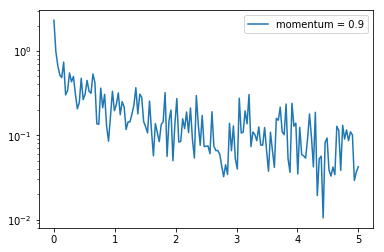

In [11]:
x_axis = np.linspace(0, 5, len(losses1), endpoint = True)
plt.semilogy(x_axis, losses1, label = 'momentum = 0.9')
plt.legend(loc = 'best')

我们可以对比一下不加动量的随机梯度下降法

In [12]:
net2 = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10))

optimizer = t.optim.SGD(net2.parameters(), lr = 0.01) #不加动量

#开始训练
losses2 = []
idx = 0
start = time.time()
for e in range(5):
    train_loss = 0
    for value, label in train_data:
        #前向传播
        out = net2(value)
        loss = critersion(out, label)
        
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #计算误差
        train_loss += loss.data.item()
        if idx % 30 == 0:
            losses2.append(loss.data.item())
        idx += 1
    print('epoch:{}, train_loss:{:.6f}'.format(e, train_loss / len(train_data)))
    
end = time.time()
print('训练时间:{:.6f}'.format(end - start))

epoch:0, train_loss:0.732291
epoch:1, train_loss:0.363924
epoch:2, train_loss:0.317841
epoch:3, train_loss:0.290152
epoch:4, train_loss:0.268043
训练时间:94.592746


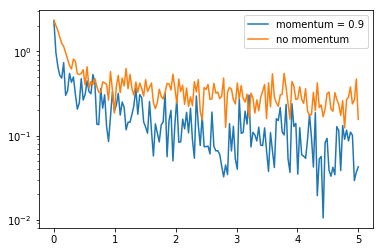

In [13]:
x_axis = np.linspace(0, 5, len(losses1), endpoint = True)
plt.semilogy(x_axis, losses1, label = 'momentum = 0.9')
plt.semilogy(x_axis, losses2, label = 'no momentum')
plt.legend(loc = 'best')

可以看到加完动量之后的 loss 下降的程度更低了，可以将动量理解为一种惯性作用，所以每次更新的幅度都会比不加动量的情况更多